### Data Labeling

In [3]:
import os
import time
import pandas as pd
from openai import OpenAI

In [ ]:
# --------------------------
# CONFIG
# --------------------------
API_KEY = "csk-tv5netvcrc4twpxt8p9vt9jmyny496ndwhrdjtjf5p2ntecr"
MODEL = "qwen-3-235b-a22b-instruct-2507"
MAX_REQUESTS_PER_MIN = 25
SLEEP_TIME = 64

# Label yang tersedia
LABELS = [
    "Proud",
    "Trust",
    "Joy",
    "Surprise",
    "Neutral",
    "Sadness",
    "Fear",
    "Anger"
]

# Prompt instruksi klasifikasi
PROMPT_TEMPLATE = """
Anda adalah seorang ahli klasifikasi emosi yang sangat akurat.
Tugas Anda adalah mengklasifikasikan teks berikut ke dalam salah satu dari delapan label emosi:
'Proud', 'Trust', 'Joy', 'Surprise', 'Neutral', 'Sadness', 'Fear', 'Anger'.

Gunakan aturan berikut:
1. Pertimbangkan semua label dengan adil (setiap label sama pentingnya).
2. Namun, dalam data nyata, emosi yang paling sering muncul adalah:
   - Surprise (paling sering, hampir setengah dari data).
   - Trust (cukup sering, sekitar seperlima).
   - Proud (cukup sering).
   - Joy, Anger, Sadness, Fear, dan Neutral lebih jarang.
   Maka, jika teks ambigu dan bisa masuk beberapa label, prioritaskan Surprise, Trust, atau Proud.
3. Pilih label minoritas (Joy, Anger, Sadness, Fear, Neutral) hanya jika ada indikasi kuat ke arah sana.
4. Definisi singkat label:
   - Proud: rasa bangga karena pencapaian/prestasi.
   - Trust: rasa percaya, yakin, atau aman.
   - Joy: bahagia, gembira, tertawa, senang.
   - Surprise: kaget, terkejut, hal tidak terduga.
   - Neutral: netral, informatif, tidak menunjukkan emosi.
   - Sadness: sedih, kecewa, kehilangan.
   - Fear: khawatir, cemas, takut.
   - Anger: marah, kesal, benci.
5. Jika teks sangat ambigu atau tidak jelas emosinya, gunakan Neutral.

Teks untuk diklasifikasikan: "{text}"

Berdasarkan teks di atas, tentukan label emosi yang paling sesuai.
JAWAB HANYA DENGAN SATU KATA DARI DAFTAR LABEL DI ATAS. JANGAN TAMBAHKAN PENJELASAN APAPUN.
"""


In [4]:
# --------------------------
# KONEKSI CLIENT
# --------------------------
client = OpenAI(api_key=API_KEY, base_url="https://api.cerebras.ai/v1")

In [5]:
# --------------------------
# HELPER FUNCTION
# --------------------------
def classify_text(text: str) -> str:
    """Kirim teks ke API untuk klasifikasi emosi."""
    prompt = PROMPT_TEMPLATE.format(labels="\n".join(LABELS), text=text)
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "Anda adalah asisten untuk klasifikasi emosi."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    label = response.choices[0].message.content.strip()
    return label

def process_file(input_path: str, output_path: str, is_train: bool = False):
    """Proses klasifikasi untuk satu file (train/test)."""
    df = pd.read_csv(input_path)

    # jika file hasil sudah ada, load agar bisa resume
    if os.path.exists(output_path):
        done_df = pd.read_csv(output_path)
        done_ids = set(done_df["id"].astype(str))
        print(f"Melanjutkan, sudah ada {len(done_ids)} data di {output_path}")
    else:
        done_df = pd.DataFrame(columns=["id", "text", "label"])
        done_ids = set()

    new_rows = []
    request_count = 0

    for _, row in df.iterrows():
        idx = str(row["id"])
        text = str(row["text"])

        # Skip jika sudah diprediksi
        if idx in done_ids:
            continue

        try:
            label = classify_text(text)
            new_rows.append({"id": idx, "text": text, "label": label})
            request_count += 1
            print(f"✅ ID {idx} -> {label}")
        except Exception as e:
            print(f"⚠️ Error pada ID {idx}: {e}")
            break  # agar tidak infinite loop jika error parah

        # Rate limit handling
        if request_count >= MAX_REQUESTS_PER_MIN:
            # Simpan progress
            pd.concat([done_df, pd.DataFrame(new_rows)]).to_csv(output_path, index=False)
            print(f"💾 Progress disimpan ke {output_path}. Menunggu {SLEEP_TIME} detik...")
            time.sleep(SLEEP_TIME)
            request_count = 0
            done_df = pd.read_csv(output_path)  # refresh done data
            done_ids = set(done_df["id"].astype(str))
            new_rows = []

    # Simpan hasil terakhir
    if new_rows:
        pd.concat([done_df, pd.DataFrame(new_rows)]).to_csv(output_path, index=False)
        print(f"💾 Hasil akhir disimpan ke {output_path}")

In [6]:
# --------------------------
# MAIN EXECUTION
# --------------------------
if __name__ == "__main__":
    # Proses datatest
    process_file("data/final_datatest.csv", "data/pred_datatest.csv", is_train=False)

    # Proses datatrain (abaikan label lama)
    process_file("data/final_datatrain.csv", "data/pred_datatrain.csv", is_train=True)

Melanjutkan, sudah ada 200 data di data/pred_datatest.csv
Melanjutkan, sudah ada 700 data di data/pred_datatrain.csv
✅ ID 750 -> Neutral
✅ ID 750 -> Neutral
✅ ID 751 -> Fear
✅ ID 751 -> Fear
✅ ID 752 -> Fear
✅ ID 752 -> Fear
✅ ID 753 -> Anger
✅ ID 753 -> Anger
✅ ID 754 -> Neutral
✅ ID 754 -> Neutral
✅ ID 755 -> Fear
✅ ID 755 -> Fear
✅ ID 756 -> Neutral
✅ ID 756 -> Neutral
✅ ID 757 -> Sadness
✅ ID 757 -> Sadness
✅ ID 758 -> Fear
✅ ID 758 -> Fear
✅ ID 759 -> Joy
✅ ID 759 -> Joy
✅ ID 760 -> Neutral
✅ ID 760 -> Neutral
✅ ID 761 -> Fear
✅ ID 761 -> Fear
✅ ID 762 -> Joy
✅ ID 762 -> Joy
✅ ID 763 -> Neutral
✅ ID 763 -> Neutral
✅ ID 764 -> Joy
✅ ID 764 -> Joy
✅ ID 765 -> Fear
✅ ID 765 -> Fear
✅ ID 766 -> Neutral
✅ ID 766 -> Neutral
✅ ID 767 -> Joy
✅ ID 767 -> Joy
✅ ID 768 -> Anger
✅ ID 768 -> Anger
✅ ID 769 -> Neutral
✅ ID 769 -> Neutral
✅ ID 770 -> Joy
✅ ID 770 -> Joy
✅ ID 771 -> Neutral
✅ ID 771 -> Neutral
✅ ID 772 -> Surprise
✅ ID 772 -> Surprise
✅ ID 773 -> Neutral
✅ ID 773 -> Neutral
✅ ID 

📊 Distribusi Label pada pred_datatrain.csv:
          Count  Percentage
label                      
Joy         359       47.68
Neutral     151       20.05
Proud       105       13.94
Anger        49        6.51
Trust        41        5.44
Fear         28        3.72
Sadness      12        1.59
Surprise      8        1.06


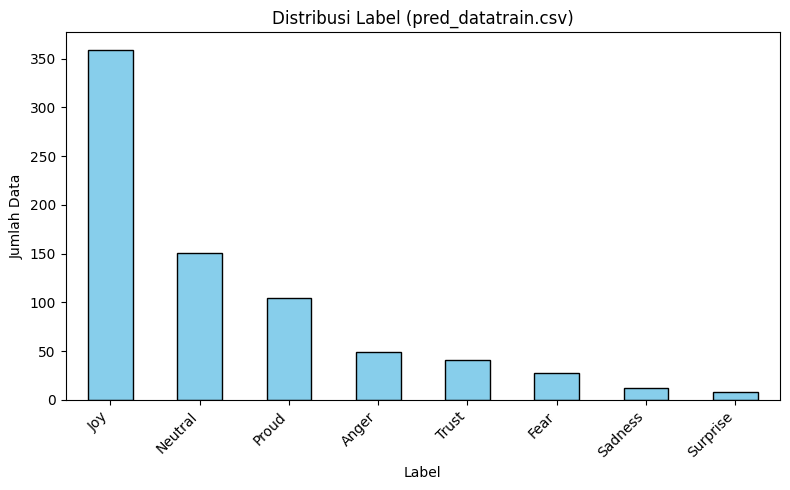

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load hasil prediksi train
df = pd.read_csv("data/pred_datatrain.csv")

# Hitung distribusi label
label_counts = df["label"].value_counts()
label_percent = df["label"].value_counts(normalize=True) * 100

# Gabungkan ke dalam dataframe ringkas
summary = pd.DataFrame({
    "Count": label_counts,
    "Percentage": label_percent.round(2)
})

print("📊 Distribusi Label pada pred_datatrain.csv:")
print(summary)

# Visualisasi
plt.figure(figsize=(8, 5))
label_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribusi Label (pred_datatrain.csv)")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()